# Import libraries and define useful functions

In [1]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from scipy.stats import kstest, ks_2samp, pearsonr
import seaborn as sns
import warnings
import os
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
import random
from google.colab import drive
# ! pip install imblearn
drive.mount('/gdrive')
%cd "/gdrive/MyDrive/Colab Notebooks/Fintech"

parent_dir = os.getcwd()
model_folder_path = os.path.join(parent_dir, "plots") 
if os.path.isdir(model_folder_path) == False:
    os.makedirs(model_folder_path) 

def plot_feature_stationary(feature_name, lw=3, figsize = (15, 10)):
    plt.figure(figsize = figsize)
    plt.plot(d_stationary[feature_name], linewidth = lw, color = "darkorange")
    anomaly_indices=np.argwhere(y_cat[:,0] == 1)[:,0]
    lb = np.min(d_stationary[feature_name])-0.1
    ub = np.abs(lb) + np.max(d_stationary[feature_name])+0.1
    plt.bar(x=anomaly_indices, height=ub, bottom = lb)
    plt.show()

def plot_feature(feature_name, lw=3, figsize = (15, 10)):
    plt.figure(figsize = figsize)
    plt.plot(d[feature_name], linewidth = lw, color = "darkorange")
    anomaly_indices=np.argwhere(y_cat[:,0] == 1)[:,0]
    lb = np.min(d[feature_name])-0.1
    ub = np.abs(lb) + np.max(d[feature_name])+0.1
    plt.bar(x=anomaly_indices, height=ub, bottom = lb)
    plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/Colab Notebooks/Fintech


# Load data

In [2]:
mat = scipy.io.loadmat('EWS.mat')
names = list(mat.keys())[3:-2]
y = mat["Y"]
y_cat = np.zeros_like(y, dtype = int)
y_cat[y[:,0]==1.0,0] = 1
col = []
times = np.arange(y.shape[0])
for ipsilon in y:
    if ipsilon == 1.0:
        col.append("red")
    else:
        col.append("blue")
d = {}
for i, name in enumerate(names):
    if name != "None":
        d[name] = mat[names[i]]


# Impose stationarity and explore the dataset

In [3]:
Indices_Currencies = ["XAUBGNL", "BDIY", "CRY", "Cl1", "DXY", "EMUSTRUU", "GBP", "JPY", "LF94TRUU", "LF98TRUU", "LG30TRUU", "LMBITR", "LP01TREU", "LUACTRUU", "LUMSTRUU", "MXBR", "MXCN", "MXEU", "MXIN", "MXJP", "MXRU", "MXUS", "VIX"]

InterestRates = ["EONIA", "GTDEM10Y", "GTDEM2Y", "GTDEM30Y", "GTGBP20Y", "GTGBP2Y", "GTGBP30Y", "GTITL10YR", "GTITL2YR", "GTITL30YR", "GTJPY10YR", "GTJPY2YR", "GTJPY30YR", "US0001M", "USGG3M", "USGG2YR", "GT10", "USGG30YR"]

response_cat = y_cat[1:, 0]
response = y[1:, 0]

d_stationary = {}
for feature_name in list(d.keys()):
    if feature_name in Indices_Currencies:
        temp = np.log(d[feature_name])
        d_stationary[feature_name] = temp[1:] - temp[:-1]
        d_stationary[feature_name] = d_stationary[feature_name].reshape(-1,)
        # d_stationary[feature_name] = np.log(d[feature_name][1:] / d[feature_name][1:])
    elif feature_name == "ECSURPUS":
        d_stationary[feature_name] = d[feature_name][1:]
        d_stationary[feature_name] = d_stationary[feature_name].reshape(-1,)
    elif feature_name in InterestRates:
        d_stationary[feature_name] = d[feature_name][1:] - d[feature_name][:-1]
        d_stationary[feature_name] = d_stationary[feature_name].reshape(-1,)


Check the variance of the features: if a feature has a low variance, it will be discarded in the feature selection / dimensionality reduction stage.

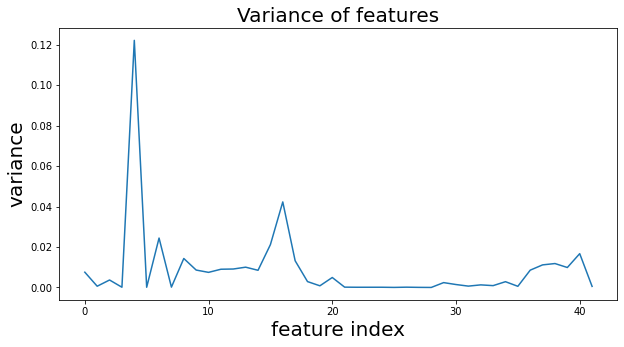

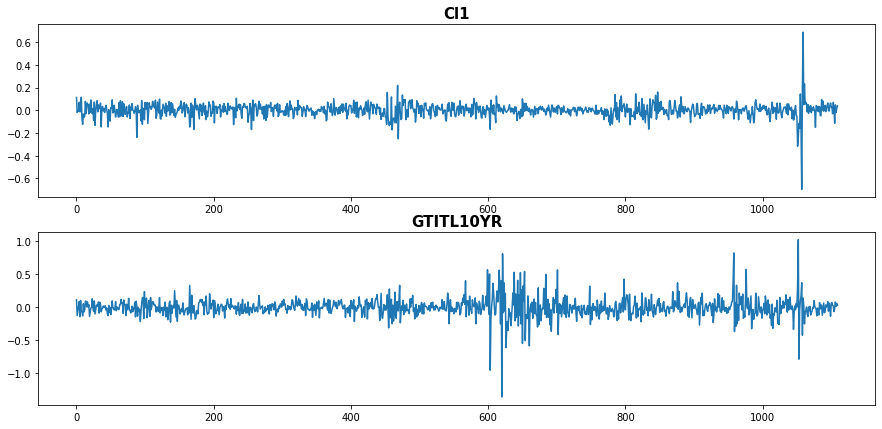

In [4]:
variances = []
for column in d_stationary.keys():
    variances.append(np.var(d_stationary[column]))

plt.figure(figsize = (10,5))
plt.plot(variances)
plt.title("Variance of features", fontsize=20)
plt.xlabel("feature index", fontsize=20)
plt.ylabel("variance", fontsize=20)
plt.savefig('plots' + os.sep + 'variance')

variances = np.array(variances).reshape(-1,)
small_variance_index = np.argwhere(variances <= 0.01)
small_variance_index = small_variance_index.ravel()

# plot of some of the low-variance features
fig, axs = plt.subplots(2, 1, figsize = (15,7))
count = 0
plot_list = np.array([2, 15]).reshape(-1,)
for j in range(2):
    plot_nome = list(d_stationary.keys())[plot_list[count]]
    axs[j].plot(d_stationary[plot_nome])
    axs[j].set_title(plot_nome, fontsize=15, loc = "center", fontweight = 1000)
    count += 1
  
fig.savefig('plots' + os.sep + 'small_variance_plot')

As seen, some features seem to have a very low variation when compared to the others.

Augmented dickey fuller test for stationarity and Komogorov Smirnov test for equality in distribution:

Text(0.5, 1.0, 'VIX Index - Non Stationary')

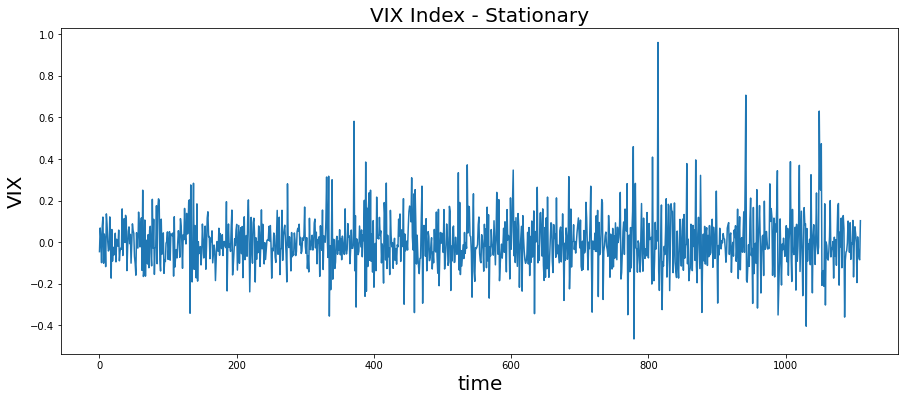

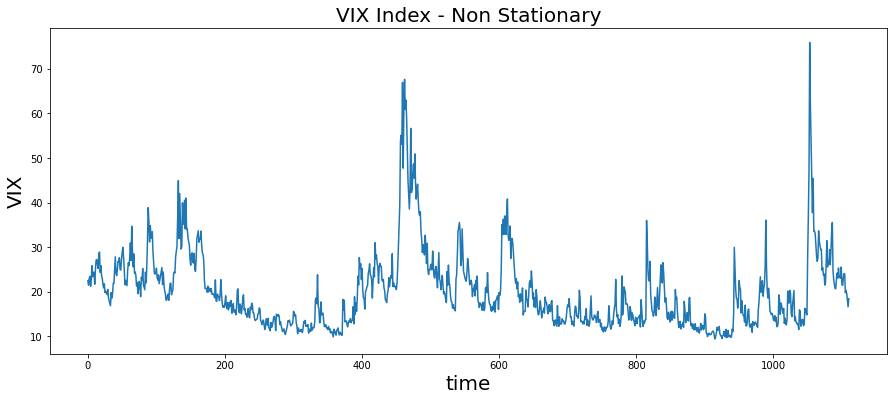

In [5]:
plt.figure(figsize = (15, 6))
plt.plot(d_stationary["VIX"])
plt.xlabel("time", fontsize=20)
plt.ylabel("VIX", fontsize=20)
plt.title("VIX Index - Stationary", fontsize=20)

# plt.show()
# plt.savefig('plots' + os.sep + 'stationary_VIX')

plt.figure(figsize = (15, 6))
plt.plot(d["VIX"])
plt.xlabel("time", fontsize=20)
plt.ylabel("VIX", fontsize=20)
plt.title("VIX Index - Non Stationary", fontsize=20)

# plt.show()
# plt.savefig('plots' + os.sep + 'non_stationary_VIX')

Confirm stationarity of the features using Augmented Dickey Fuller test:

Text(0.5, 1.0, 'Augmented Dickey Fuller Test - p-values')

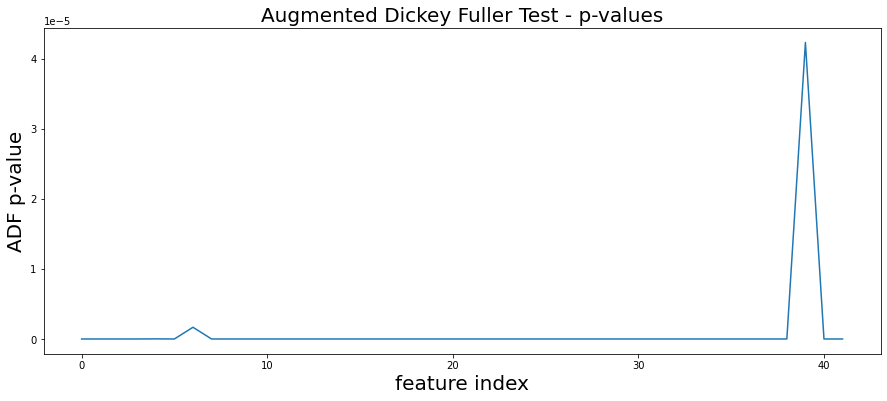

In [6]:
adf_pvalues = {}
for feature_name in list(d_stationary.keys()):
    temp = adfuller(list(d_stationary[feature_name]))
    adf_pvalues[feature_name] = temp[1]
    
# chech if stationarity has been obtained
plt.figure(figsize = (15, 6))
plt.plot(list(adf_pvalues.values()))
plt.ylabel("ADF p-value", fontsize=20)
plt.xlabel("feature index", fontsize=20)
plt.title("Augmented Dickey Fuller Test - p-values", fontsize=20)
# plt.show()
# plt.savefig('plots' + os.sep + 'adf_pvalues')

# Feature selection and dimensionality reduction
We reduced the number of features based on the follwing steps:
1.   Use Kolmogor Smirnov test to assess whether the distribution of the features is different during risk-on and risk-off periods: if so, then the feature can be useful in classifying the time stamps: otherwise, it can be discarded.
2.   Out of the remaining features after step 1, reduce dimensionality by looking at correlation: if a group of features is highli correlated, then keep only one of them,
3.   Select the features which are financially related with the task under study.
4.   Focus on features related to Europe or the USA.



Names of features with high p-value: [['GTITL10YR']
 ['GTITL30YR']
 ['GTJPY2YR']
 ['GTJPY30YR']
 ['JPY']
 ['LF94TRUU']
 ['LUACTRUU']
 ['XAUBGNL']]


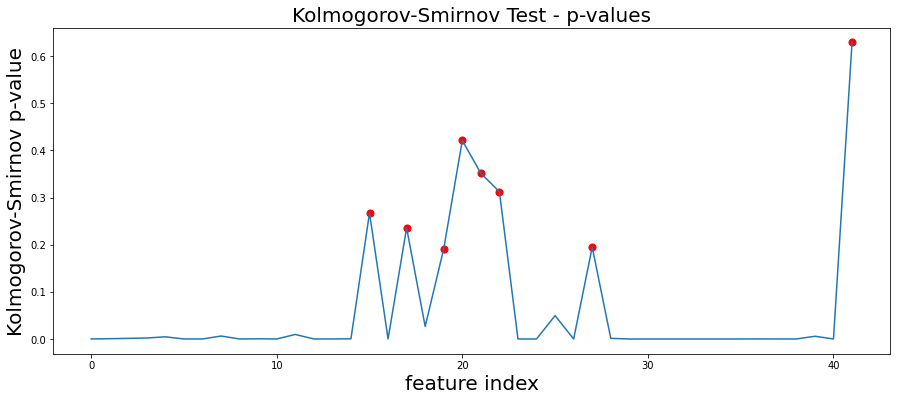

In [7]:
ks_pvalues = {}
for feature_name in list(d_stationary.keys()):
    datum = d_stationary[feature_name]
    # list(np.argwhere(y_cat[:,0] == 0).reshape(-1,))
    datum_0 = datum[np.argwhere(y_cat[1:,0] == 0)].reshape(-1,)
    datum_1 = datum[np.argwhere(y_cat[1:,0] == 1)].reshape(-1,)
    temp = ks_2samp(datum_0, datum_1)
    ks_pvalues[feature_name] = temp[1]


plt.figure(figsize = (15, 6))
names_array = np.array(list(ks_pvalues.keys()))
ks_pvalues = np.array(list((ks_pvalues.values())))
plt.plot(ks_pvalues)
high_pval = np.argwhere(np.array(ks_pvalues) > 0.05)
plt.scatter(high_pval.ravel(), ks_pvalues[high_pval.ravel()], c = "red", s = 50)
plt.ylabel("Kolmogorov-Smirnov p-value", fontsize=20)
plt.xlabel("feature index", fontsize=20)
plt.title("Kolmogorov-Smirnov Test - p-values", fontsize=20)
# plt.show()
# plt.savefig('plots' + os.sep + 'ks_pvalues')

print("Names of features with high p-value:", names_array[high_pval])

features to remove:
```
                     array([['GTITL10YR'],
                            ['GTITL30YR'],
                            ['GTJPY2YR'],
                            ['GTJPY30YR'],
                            ['JPY'],
                            ['LF94TRUU'],
                            ['LUACTRUU'],
                            ['XAUBGNL']], dtype='<U9')
```

Correlation-based feature selection:

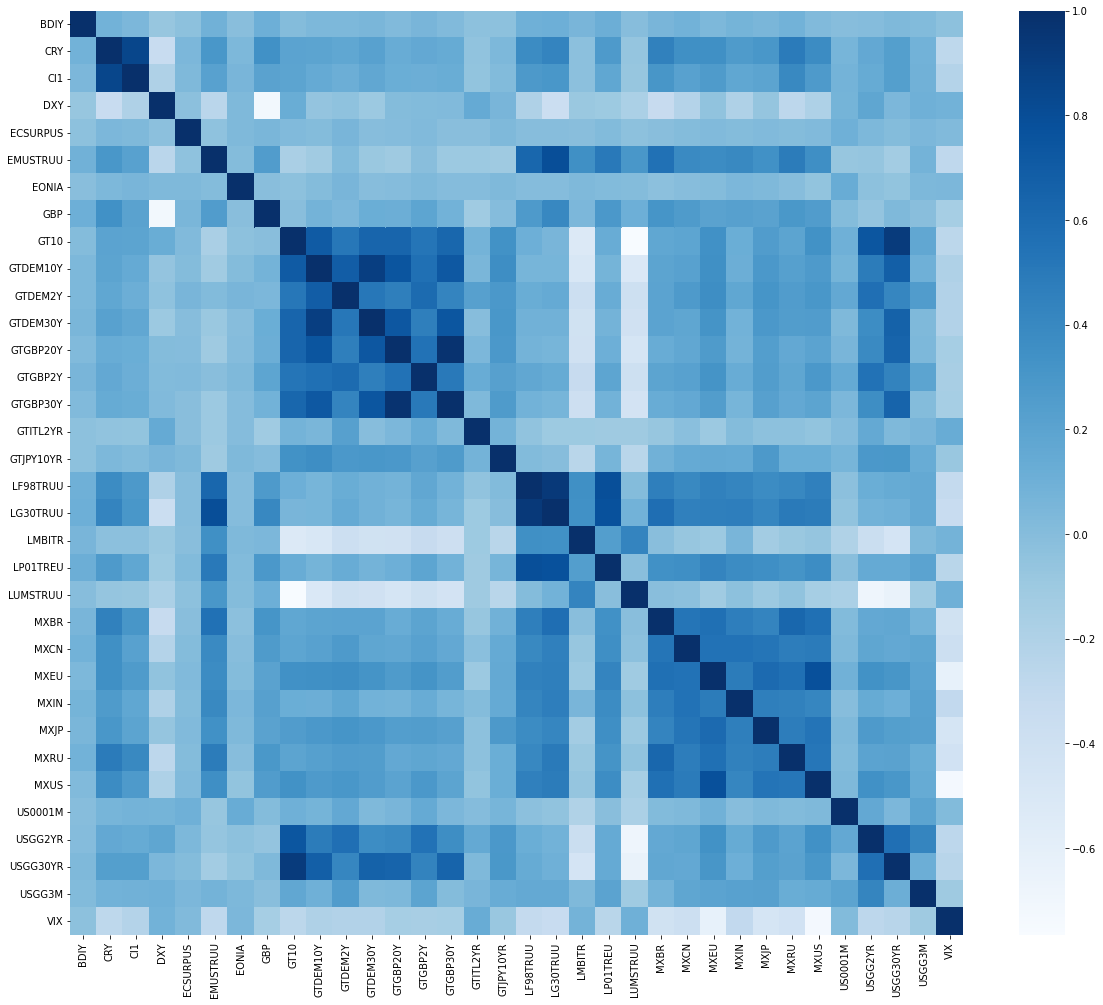

In [8]:
df = pd.DataFrame(d_stationary)
df_1 = df.drop(df.columns[list(high_pval[:,0])], axis=1)
corr_matrix = df_1.corr()
fig, ax = plt.subplots(figsize=(20,17))  
sns.heatmap(corr_matrix, 
        xticklabels=corr_matrix.columns,
        yticklabels=corr_matrix.columns,
        cmap = "Blues")

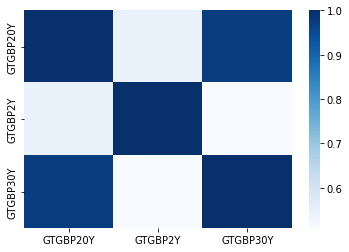

In [10]:
british_bonds = ['GTGBP20Y', 'GTGBP2Y','GTGBP30Y']
corr_matrix = df_1.loc[:,british_bonds].corr()
# fig, ax = plt.subplots(figsize=(20,17))  
sns.heatmap(corr_matrix, 
        xticklabels=corr_matrix.columns,
        yticklabels=corr_matrix.columns,
        cmap = "Blues")
# keep only 2 yrs
df_1 = df_1.drop(['GTGBP20Y','GTGBP30Y'], axis=1)

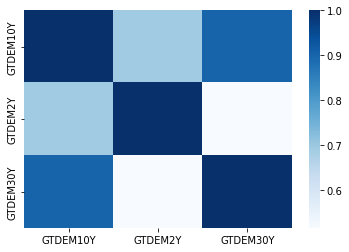

In [11]:
german_bonds = ['GTDEM10Y', 'GTDEM2Y', 'GTDEM30Y']
corr_matrix = df_1.loc[:,german_bonds].corr()
# fig, ax = plt.subplots(figsize=(20,17))  
sns.heatmap(corr_matrix, 
        xticklabels=corr_matrix.columns,
        yticklabels=corr_matrix.columns,
        cmap = "Blues")
# keep only 2 yrs
df_1 = df_1.drop(['GTDEM10Y','GTDEM30Y'], axis=1)

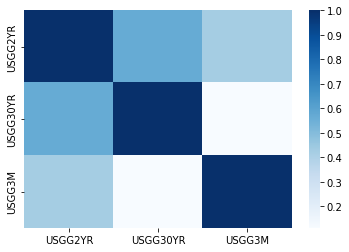

In [12]:
us_bonds = ['USGG2YR', 'USGG30YR', 'USGG3M']
corr_matrix = df_1.loc[:,us_bonds].corr()
# fig, ax = plt.subplots(figsize=(20,17))  
sns.heatmap(corr_matrix, 
        xticklabels=corr_matrix.columns,
        yticklabels=corr_matrix.columns,
        cmap = "Blues")
# keep only 2 yrs and 3 months
df_1 = df_1.drop(['USGG30YR'], axis=1)

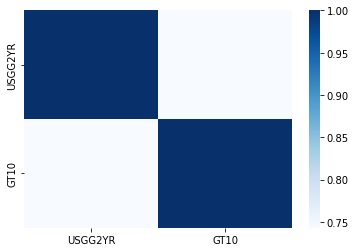

In [13]:
us_bonds = ['USGG2YR', 'GT10']
corr_matrix = df_1.loc[:,us_bonds].corr()
# fig, ax = plt.subplots(figsize=(20,17))  
sns.heatmap(corr_matrix, 
        xticklabels=corr_matrix.columns,
        yticklabels=corr_matrix.columns,
        cmap = "Blues")
# keep only 2 yrs
df_1 = df_1.drop(['GT10'], axis=1)

In [14]:
df_1 = df_1.drop(['Cl1', "LG30TRUU", "LF98TRUU", "LP01TREU", "LMBITR"], axis=1)

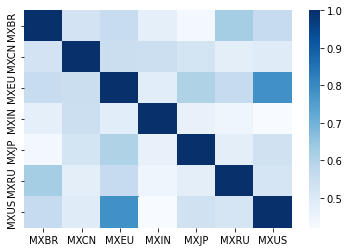

In [15]:
market_indices = ["MXBR", "MXCN", "MXEU", "MXIN", "MXJP", "MXRU", "MXUS"]
corr_matrix = df_1.loc[:,market_indices].corr()
# fig, ax = plt.subplots(figsize=(20,17))  
sns.heatmap(corr_matrix, 
        xticklabels=corr_matrix.columns,
        yticklabels=corr_matrix.columns,
        cmap = "Blues")
# we keep them all

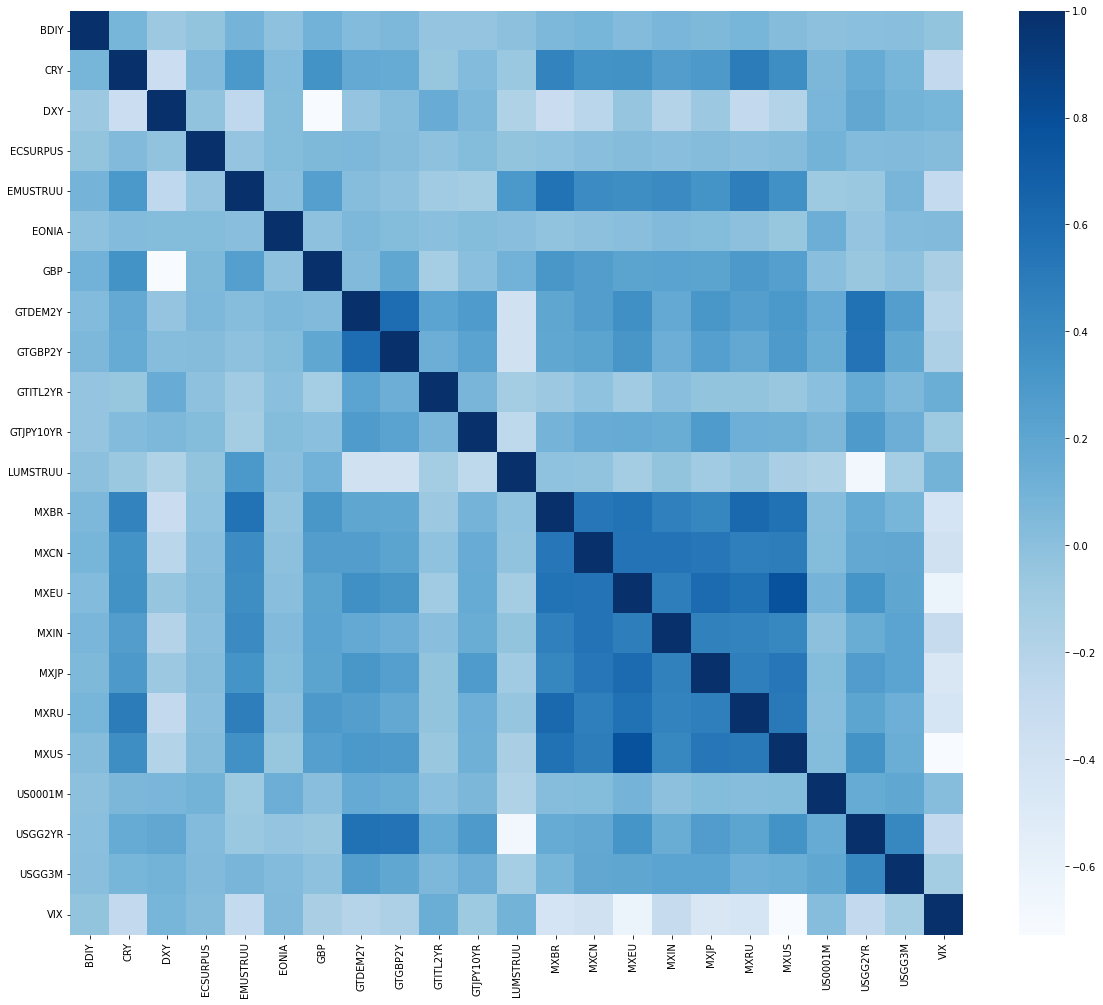

In [16]:
corr_matrix = df_1.corr()
fig, ax = plt.subplots(figsize=(20,17))  
sns.heatmap(corr_matrix, 
        xticklabels=corr_matrix.columns,
        yticklabels=corr_matrix.columns,
        cmap = "Blues")

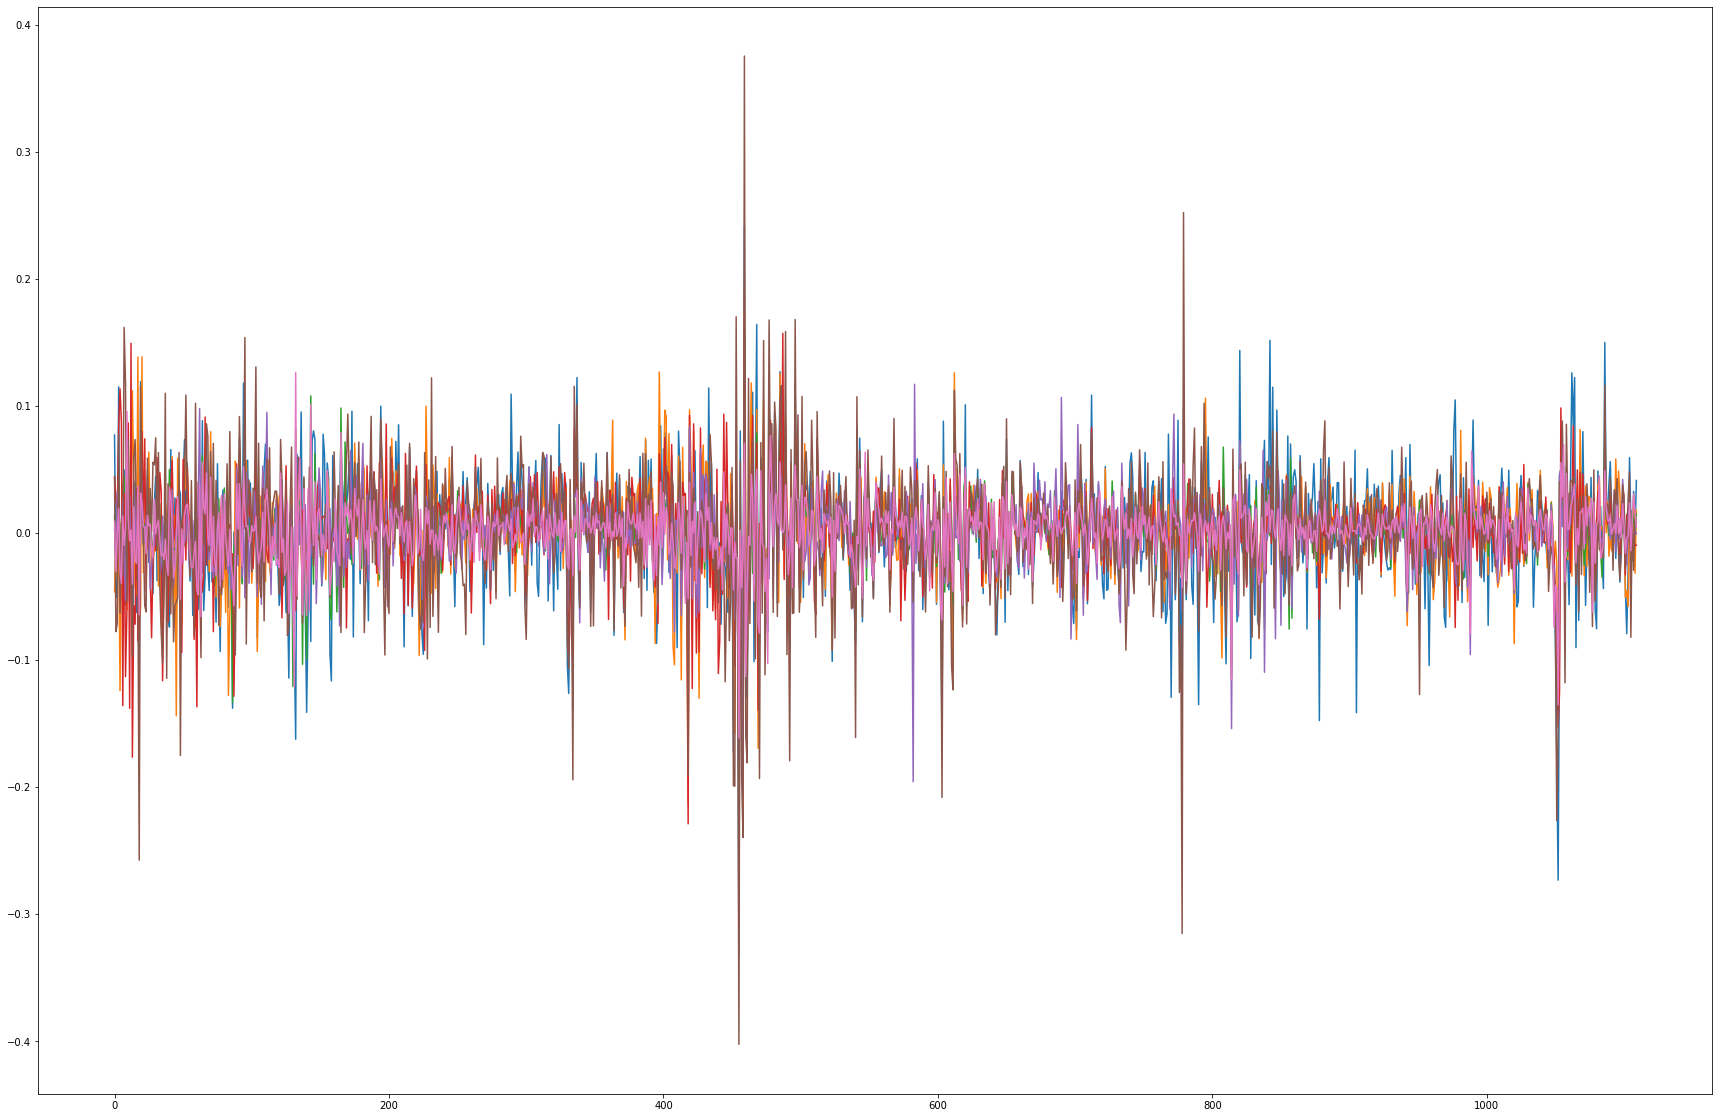

In [17]:
plt.figure(figsize = (30,20))
plt.plot(df_1.loc[:,market_indices])
plt.show()

We choose to focus on USA and EU:

In [18]:
df_1 = df_1.drop(["MXCN","MXIN", "MXJP", "MXRU"], axis=1)

In [19]:
df_1 = df_1.drop(["GTJPY10YR"], axis=1)

In [20]:
df_1 = df_1.drop(["US0001M"], axis=1)

In [21]:
df_1 = df_1.drop(["GBP"], axis=1)

In [22]:
df_1 = df_1.drop(["EMUSTRUU", "LUMSTRUU", "USGG3M", "DXY", "GTITL2YR", "ECSURPUS"], axis=1)

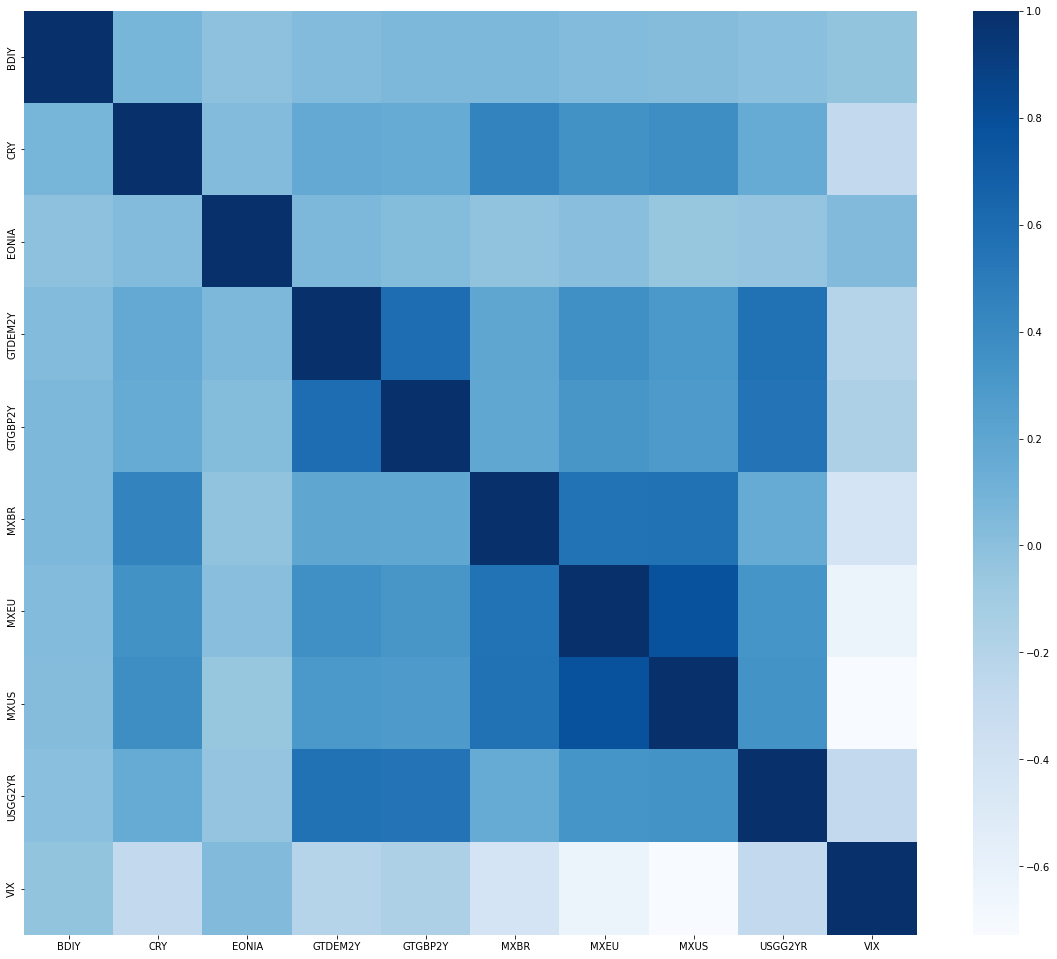

In [23]:
corr_matrix = df_1.corr()
fig, ax = plt.subplots(figsize=(20,17))  
sns.heatmap(corr_matrix, 
        xticklabels=corr_matrix.columns,
        yticklabels=corr_matrix.columns,
        cmap = "Blues")

Final features:

```
['BDIY', 'CRY', 'EONIA', 'GTDEM2Y', 'GTGBP2Y', 'MXBR', 'MXEU', 'MXUS', 'USGG2YR', 'VIX']
```



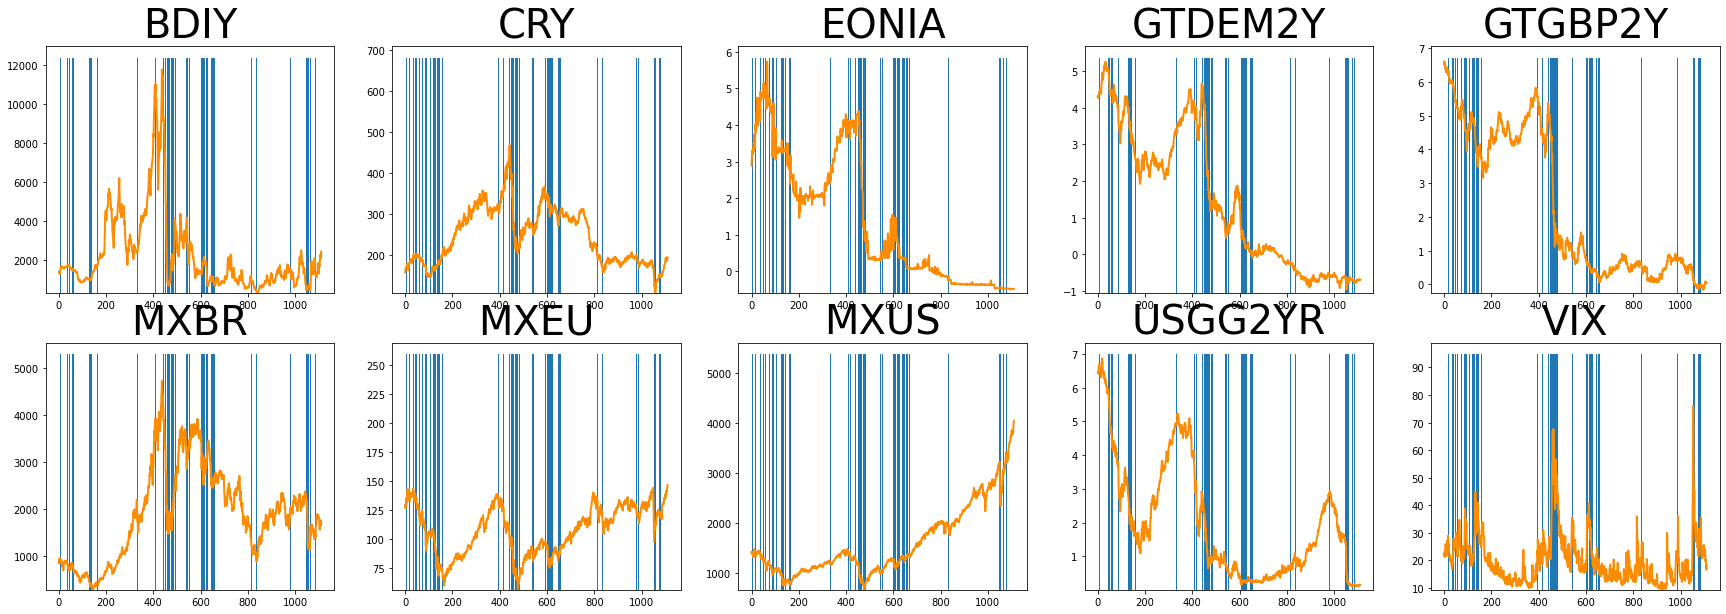

In [24]:
fig, axs = plt.subplots(2, 5, figsize = (30,10))
count = 0
for i in range(2):
    for j in range(5):
        feature_name_2 = df_1.columns[count]
        axs[i,j].plot(d[feature_name_2], linewidth = 2, color = "darkorange")
        anomaly_indices=np.argwhere(y_cat[:,0] == 1)[:,0]
        lb = np.min(d[feature_name_2])-0.1
        ub = np.abs(lb) + np.max(d[feature_name_2])+0.1
        axs[i,j].bar(x=anomaly_indices, height=ub, bottom = lb)
        axs[i,j].set_title(feature_name_2, fontsize=40)
        count += 1
fig.savefig('plots' + os.sep + 'final_dataset')

# Try some classification algorithms

## Isolation Forest

In [25]:
test_size = int(0.2*df_1.values.shape[0])
exclude = np.random.choice(df_1.values.shape[0], test_size, replace=False)
mask = np.ones(df_1.values.shape[0], bool)
mask[exclude] = False
y_cat_new = y_cat[1:,0]
X_train = pd.DataFrame(d_stationary).values[mask == True]
y_train = y_cat_new[mask == True]
X_test = pd.DataFrame(d_stationary).values[mask == False]
y_test = y_cat_new[mask == False]


clf = IsolationForest(contamination=0.2, n_estimators = 1000)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

y_pred_test[y_pred_test == -1] = 1
C_test = confusion_matrix(y_test,y_pred_test)
print("------------------------")
print("Performance on TEST SET:")
print("------------------------")
print("tn fn \nfp tp")
print(C_test)
print("anomalies in the test set:",sum(y_test))
print("normal points in the test set:",y_test.shape[0]-sum(y_test))
print("anomalies predicted (test set):",sum(y_pred_test))
print("normal points (test set):",y_pred_test.shape[0]-sum(y_pred_test))
recall = C_test[1,1]/(C_test[1,1] + C_test[0,1])
precision = C_test[1,1]/(C_test[1,1] + C_test[1,0])
print("recall:", recall)
print("precision:", precision)

y_pred_train[y_pred_train == -1] = 1
C_train = confusion_matrix(y_train,y_pred_train)
print("-------------------------")
print("Performance on TRAIN SET:")
print("-------------------------")
print("tn fn \nfp tp")
print(C_train)
print("anomalies in the train set:",sum(y_train))
print("normal points in the train set:",y_train.shape[0]-sum(y_train))
print("anomalies predicted (train set):",sum(y_pred_train))
print("normal points (train set):",y_pred_train.shape[0]-sum(y_pred_train))
recall = C_train[1,1]/(C_train[1,1] + C_train[0,1])
precision = C_train[1,1]/(C_train[1,1] + C_train[1,0])
print("recall:", recall)
print("precision:", precision)


------------------------
Performance on TEST SET:
------------------------
tn fn 
fp tp
[[  0 167]
 [  0  55]]
anomalies in the test set: 55
normal points in the test set: 167
anomalies predicted (test set): 222
normal points (test set): 0
recall: 0.24774774774774774
precision: 1.0
-------------------------
Performance on TRAIN SET:
-------------------------
tn fn 
fp tp
[[  0 706]
 [  0 182]]
anomalies in the train set: 182
normal points in the train set: 706
anomalies predicted (train set): 888
normal points (train set): 0
recall: 0.20495495495495494
precision: 1.0


The performance of the Isolation Forest seem quite low, possibly due to the fact that the dataset is highly imbalanced.

## k-NN with oversampling through oversampling techniques
With this approach we try to use a fairly simple model (k-NN) and try to counteract the imbalance of the dataset using an oversampling algorithm ([SMOTE](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html), [BorderlineSMOTE](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.BorderlineSMOTE.html), [ADASYN](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.ADASYN.html) and [Naive random over-sampling](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html)). Since the number of anomalies is very low (only 237 anomalies versus 873 normal points), we expect that resampling the anomalies would still not be sufficient. Please visit [this link](https://imbalanced-learn.org/stable/over_sampling.html#smote-adasyn) for a comparative study on the three oversampling methods.

In [26]:
df_original = df_1.copy()
X = df_original.values
y = y_cat[1:,:].reshape(-1,1)
original_number_of_anomalies = sum(y.ravel())

### Naive random over-sampling

In [27]:
from imblearn.over_sampling import RandomOverSampler

nros = RandomOverSampler()
X_nros, y_nros = nros.fit_resample(X, y)
new_number_of_anomalies = sum(y_nros.ravel())
delta_numer_of_anomalies = new_number_of_anomalies-original_number_of_anomalies
print("Number of new anomalies added:", delta_numer_of_anomalies)
print("NROS has added", 100*delta_numer_of_anomalies/original_number_of_anomalies, "% more anomalies.")
print("New ratio of 0-1:", {0: np.sum(y_nros==0)/y_nros.shape[0], 1: np.sum(y_nros==1)/y_nros.shape[0]})

Number of new anomalies added: 636
NROS has added 268.3544303797468 % more anomalies.
New ratio of 0-1: {0: 0.5, 1: 0.5}


In [28]:
from imblearn.over_sampling import SMOTE

# smote = SMOTE()
smote = SMOTE(sampling_strategy = 0.4, k_neighbors = 3)
X_smote, y_smote = smote.fit_resample(X, y)
new_number_of_anomalies = sum(y_smote.ravel())
delta_numer_of_anomalies = new_number_of_anomalies-original_number_of_anomalies
print("Number of new anomalies added:", delta_numer_of_anomalies)
print("SMOTE has added", 100*delta_numer_of_anomalies/original_number_of_anomalies, "% more anomalies.")
print("New ratio of 0-1:", {0: np.sum(y_smote==0)/y_smote.shape[0], 1: np.sum(y_smote==1)/y_smote.shape[0]})

Number of new anomalies added: 112
SMOTE has added 47.257383966244724 % more anomalies.
New ratio of 0-1: {0: 0.7144026186579379, 1: 0.2855973813420622}


In [29]:
from imblearn.over_sampling import BorderlineSMOTE

# bl1smote = BorderlineSMOTE(kind = "borderline-1")
# bl1smote = BorderlineSMOTE(sampling_strategy = 0.35, kind = "borderline-1")
# bl1smote = BorderlineSMOTE(sampling_strategy = 0.3, kind = "borderline-1")
bl1smote = BorderlineSMOTE(sampling_strategy = 0.4, kind = "borderline-1")
X_bl1smote, y_bl1smote = bl1smote.fit_resample(X, y)
new_number_of_anomalies = sum(y_bl1smote.ravel())
delta_numer_of_anomalies = new_number_of_anomalies-original_number_of_anomalies
print("Number of new anomalies added:", delta_numer_of_anomalies)
print("BorderlineSMOTE has added", 100*delta_numer_of_anomalies/original_number_of_anomalies, "% more anomalies.")
print("New ratio of 0-1:", {0: np.sum(y_bl1smote==0)/y_bl1smote.shape[0], 1: np.sum(y_bl1smote==1)/y_bl1smote.shape[0]})

Number of new anomalies added: 112
BorderlineSMOTE has added 47.257383966244724 % more anomalies.
New ratio of 0-1: {0: 0.7144026186579379, 1: 0.2855973813420622}


In [30]:

# bl2smote = BorderlineSMOTE(kind = "borderline-2")
# bl2smote = BorderlineSMOTE(sampling_strategy = 0.35, kind = "borderline-2")
# bl2smote = BorderlineSMOTE(sampling_strategy = 0.3, kind = "borderline-2")
bl2smote = BorderlineSMOTE(sampling_strategy = 0.4, kind = "borderline-2")
X_bl2smote, y_bl2smote = bl2smote.fit_resample(X, y)
new_number_of_anomalies = sum(y_bl2smote.ravel())
delta_numer_of_anomalies = new_number_of_anomalies-original_number_of_anomalies
print("Number of new anomalies added:", delta_numer_of_anomalies)
print("BorderlineSMOTE has added", 100*delta_numer_of_anomalies/original_number_of_anomalies, "% more anomalies.")
print("New ratio of 0-1:", {0: np.sum(y_bl2smote==0)/y_bl2smote.shape[0], 1: np.sum(y_bl2smote==1)/y_bl2smote.shape[0]})

Number of new anomalies added: 111
BorderlineSMOTE has added 46.835443037974684 % more anomalies.
New ratio of 0-1: {0: 0.714987714987715, 1: 0.28501228501228504}


In [31]:
from imblearn.over_sampling import ADASYN

# adasyn = ADASYN()
adasyn = ADASYN(sampling_strategy = 0.4)
# adasyn = ADASYN(sampling_strategy = 0.5)
X_adasyn, y_adasyn = adasyn.fit_resample(X, y)
new_number_of_anomalies = sum(y_adasyn.ravel())
delta_numer_of_anomalies = new_number_of_anomalies-original_number_of_anomalies
print("Number of new anomalies added:", delta_numer_of_anomalies)
print("ADASYN has added", 100*delta_numer_of_anomalies/original_number_of_anomalies, "% more anomalies.")
print("New ratio of 0-1:", {0: np.sum(y_adasyn==0)/y_adasyn.shape[0], 1: np.sum(y_adasyn==1)/y_adasyn.shape[0]})

Number of new anomalies added: 150
ADASYN has added 63.29113924050633 % more anomalies.
New ratio of 0-1: {0: 0.6928571428571428, 1: 0.30714285714285716}


Split into training, validation and test set. Use validation set to tune k and test set to mesure the performance.



In [32]:
def choose_k(X_val, y_val):
  with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    best_optimizing_metric = 0
    best_params = np.zeros((2,))
    best_k = -1
    for k in range(2, X_val.shape[0], 1):
      model_k = KNeighborsClassifier(n_neighbors=k)
      model_k.fit(X_val,y_val)
      y_hat_val = model_k.predict(X_val) 
      C_val = confusion_matrix(y_val,y_hat_val)
      recall = C_val[1,1]/(C_val[1,1] + C_val[0,1])
      precision = C_val[1,1]/(C_val[1,1] + C_val[1,0])
      # optimizing_metric = precision * recall / (precision + recall)
      # optimizing_metric = precision
      # optimizing_metric = recall
      # optimizing_metric = 0.95 * precision + 0.05 * recall
      optimizing_metric = 0.95 * precision + 0.05 * recall
      if optimizing_metric > best_optimizing_metric:
        best_optimizing_metric = optimizing_metric
        best_params[0] = recall
        best_params[1] = precision
        best_k = k
  return (best_k, best_params)

def random_permutation(dataset, percentage):
  final_size = int(np.floor(percentage*dataset.shape[0]))
  n = dataset.shape[0]
  idxPermutation = np.array(random.sample([index for index in range(n)], final_size)).ravel()
  idxExclude = [index_to_exlude for index_to_exlude in range(n) if index_to_exlude not in list(idxPermutation)]
  idxExclude = np.array(idxExclude).ravel()
  return idxPermutation, idxExclude

In [33]:
X_list = [X_nros, X_smote, X_bl1smote, X_bl2smote, X_adasyn]
y_list = [y_nros, y_smote, y_bl1smote, y_bl2smote, y_adasyn]
model_names = ["Naive random oversampling", "SMOTE", "Borderlne-1 SMOTE", "Borderlne-2 SMOTE", "ADASYN"]
confusion_matrices = []
models = []

for i, X_augmented in enumerate(X_list):

  print("------------------------------------------")
  print("WORKING WITH", model_names[i])
  print("------------------------------------------")

  y_augmented = y_list[i]
  test_size = int(0.2*X_augmented.shape[0])

  # create test set
  exclude = np.random.choice(X_augmented.shape[0], test_size, replace=False)
  mask = np.ones(X_augmented.shape[0], bool)
  mask[exclude] = False
  X_train_tot = X_augmented[mask == True]
  y_train_tot = y_augmented[mask == True]
  X_test = X_augmented[mask == False]
  y_test = y_augmented[mask == False]

  # create validation set
  val_size = int(0.3*X_train_tot.shape[0])
  exclude = np.random.choice(X_train_tot.shape[0], val_size, replace=False)
  mask = np.ones(X_train_tot.shape[0], bool)
  mask[exclude] = False
  X_train = X_train_tot[mask == True]
  y_train = y_train_tot[mask == True]
  X_val = X_train_tot[mask == False]
  y_val = y_train_tot[mask == False]
  

  print("train set shape and ratio of 0-1", X_train.shape, "-->", (np.sum(y_train==0)/y_train.shape[0], np.sum(y_train==1)/y_train.shape[0]))
  print("test set shape and ratio of 0-1", X_test.shape, "-->", (np.sum(y_test==0)/y_test.shape[0], np.sum(y_test==1)/y_test.shape[0]))
  print("validation set shape and ratio of 0-1", X_val.shape, "-->", (np.sum(y_val==0)/y_val.shape[0], np.sum(y_val==1)/y_val.shape[0]))

  # tune k using validation set
  best_k, best_params = choose_k(X_val, y_val)
  print("best k in CV:", best_k)
  print("best recall in CV:", best_params[0])
  print("best precision in CV:", best_params[1])

  # model = KNeighborsClassifier(n_neighbors=best_k)
  model = KNeighborsClassifier(n_neighbors=5)
  models.append(model)
  model.fit(X_train,y_train)
  predicted = model.predict(X_test)
  C = confusion_matrix(y_test,predicted)
  confusion_matrices.append(C)
  print("tn fn, \nfp tp")
  print(C)
  recall = C[1,1]/(C[1,1] + C[0,1])
  precision = C[1,1]/(C[1,1] + C[1,0])
  print("test set recall:", recall)
  print("test set precision:", precision)

------------------------------------------
WORKING WITH Naive random oversampling
------------------------------------------
train set shape and ratio of 0-1 (978, 10) --> (0.5071574642126789, 0.49284253578732107)
test set shape and ratio of 0-1 (349, 10) --> (0.49283667621776506, 0.5071633237822349)
validation set shape and ratio of 0-1 (419, 10) --> (0.4892601431980907, 0.5107398568019093)
best k in CV: 411
best recall in CV: 0.5107398568019093
best precision in CV: 1.0
tn fn, 
fp tp
[[122  50]
 [ 45 132]]
test set recall: 0.7252747252747253
test set precision: 0.7457627118644068
------------------------------------------
WORKING WITH SMOTE
------------------------------------------
train set shape and ratio of 0-1 (685, 10) --> (0.7094890510948905, 0.2905109489051095)
test set shape and ratio of 0-1 (244, 10) --> (0.7172131147540983, 0.2827868852459016)
validation set shape and ratio of 0-1 (293, 10) --> (0.7235494880546075, 0.2764505119453925)
best k in CV: 3
best recall in CV: 0.7

**The application of the over-sampling algorithms has been effective: while the copula model tends to classify many points as anomalies, the k-NN coupled with SMOTE (or other over-sampling approaches) has a more "balanced" classification matrix.**